# Visualization and Group comparison
Here we visualize and compare specific groups and conditions to check for differences.

In [1]:
# import packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# define paths
data_path = "../../../Output/Measurements/"
output_path = "../../../Output/Figures/"

choices_map = {1:'ch2 pos', 2:'ch3 pos', 3:'double pos', 4:'double neg'}

# read in data
df = (pd.read_csv(data_path + 'measurements_classification.csv')
    # .assign(condition = lambda df_: df_.condition.astype('category'),
            # bio_replicate = lambda df_: df_.bio_replicate.astype('category'),
            # cat_string = lambda df_: df_.cat_string.astype('category'))
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60020 entries, 0 to 60019
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Image                   60020 non-null  object 
 1   Channel 2: Mean         60020 non-null  float64
 2   Channel 3: Mean         60020 non-null  float64
 3   Channel 2: Mean_bkg_C2  60020 non-null  float64
 4   Channel 3: Mean_bkg_C3  60020 non-null  float64
 5   Centroid X µm           60020 non-null  float64
 6   Centroid Y µm           60020 non-null  float64
 7   ch2_bg_sub              60020 non-null  float64
 8   ch3_bg_sub              60020 non-null  float64
 9   date                    60020 non-null  object 
 10  project                 60020 non-null  object 
 11  plasmid_number          60020 non-null  int64  
 12  female_number           60020 non-null  object 
 13  embryo_number           60020 non-null  int64  
 14  slide_number            60020 non-null

In [4]:
# Plot all cells categorization per condition
sns.set(context='talk')

choices_map = {1:'ch2 pos', 2:'ch3 pos', 3:'double pos', 4:'double neg'}
df['cat_string'] = df['category_otsu'].map(choices_map)

g = sns.relplot(data=df, x='ch2_bg_sub', y='ch3_bg_sub', s=5, 
                hue='cat_string', palette='tab10', legend=True,
                col='condition', col_wrap=4)

# Comment below if you don't want the annotations
for (i,j,k), data in g.facet_data():
    cat_counts = data.groupby('cat_string')['Image'].count()
    ax = g.facet_axis(i,j)
    # add dashed lines
    ax.axvline(317.0325416015625, ls='--', color='gray', alpha=0.4) # calculated threshold for channel 2
    ax.axhline(231.41744882812498, ls='--', color='gray', alpha=0.4) # calculated threshold for channel 3
    # add count annotations to scatterplot
    ax.text(x=0.95, y = 0.05, s=str(cat_counts[0]), transform=ax.transAxes, fontsize=10, ha='center', bbox=dict(boxstyle="square", fc='white', alpha=0.5))
    ax.text(x=0.05, y = 0.95, s=str(cat_counts[1]), transform=ax.transAxes, fontsize=10, ha='center', bbox=dict(boxstyle="square", fc='white', alpha=0.5))
    ax.text(x=0.05, y = 0.05, s=str(cat_counts[2]), transform=ax.transAxes, fontsize=10, ha='center', bbox=dict(boxstyle="square", fc='white', alpha=0.5))
    ax.text(x=0.95, y = 0.95, s=str(cat_counts[3]), transform=ax.transAxes, fontsize=10, ha='center', bbox=dict(boxstyle="square", fc='white', alpha=0.5))


g.set(xlabel='Channel 2', ylabel='Channel 3')
g._legend.set_title('Cell category')
plt.suptitle('All cells all conditions categories\nAfter background subtraction', y=1.05)
plt.savefig(output_path + 'all_conditions_scatterplot_annotated.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization per Image

In [5]:
# Calculate percentage of occurance for each category per Image
img_percentage = df.groupby(['Image'])['cat_string'].value_counts(normalize=True).mul(100).to_frame().rename(columns={'cat_string':'percentage'}).reset_index()

# Select only conditions 2 and 4 for comparison
df_to_plot = (
    img_percentage
    .merge(df[['Image', 'bio_replicate', 'condition', 'date']].drop_duplicates(), on ='Image')
    .query("condition in [2,4]") # category != 4 and 
    .sort_values('condition')
    .assign(condition = lambda df_: df_.condition.astype("str"))
)

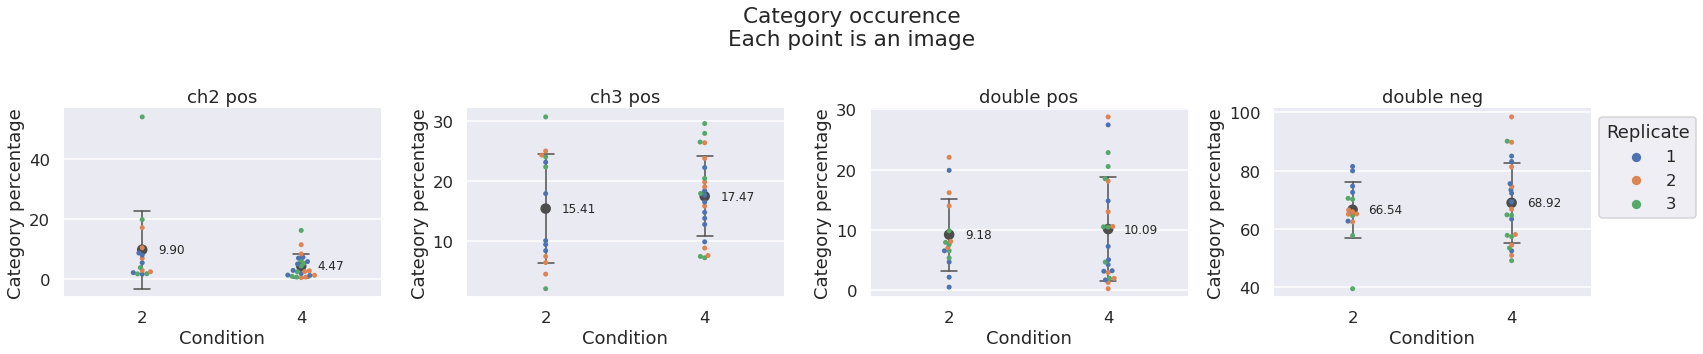

In [6]:
# SuperPlot of conditions 2 and 4 with a point for each Image file and mean and STD error bar
g = sns.catplot(data=df_to_plot, x='condition', y='percentage', hue='bio_replicate', col='cat_string', col_order=['ch2 pos', 'ch3 pos', 'double pos', 'double neg'],
                aspect=1.2, kind='swarm', sharey=False, legend=False)

g.set_titles(col_template='{col_name}')


for (i,j,k), data in g.facet_data():
    ax = g.facet_axis(i,j)
    sns.pointplot(data=data, x='condition', y='percentage', join=False, ci='sd', scale=0.8, capsize=0.1, errwidth=1.5, color='0.3')
    
    percentage_values = data.groupby('condition')['percentage'].mean()
    ax.text(x=0.1, y=percentage_values[0], s="{:.2f}".format(percentage_values[0]), va='center', fontsize=12)
    ax.text(x=1.1, y=percentage_values[1], s="{:.2f}".format(percentage_values[1]), va='center', fontsize=12)
    

g.set(xlabel='Condition', ylabel='Category percentage')
plt.legend(bbox_to_anchor=(1,1), title='Replicate')
plt.suptitle('Category occurence\nEach point is an image', y=1)
plt.tight_layout()
plt.savefig(output_path + 'categories_superplot.png', dpi=300, bbox_inches='tight')
plt.show()

## One value per group

In [19]:
# Calculate percentage per condition
val_counts = df.groupby('condition')['category'].agg(['value_counts'])
counts = df.groupby('condition')['category'].count().reset_index().rename(columns={'category':'total_num'})
cell_pctg = val_counts.reset_index().merge(counts, on='condition')
cell_pctg['percentage'] = cell_pctg['value_counts'] / cell_pctg['total_num'] * 100
cell_pctg.sort_values(['category', 'condition'], inplace=True)
cell_pctg['cat_string'] = cell_pctg['category'].map(choices_map)

In [ ]:
# Make stacked bar for visualizing everything together
groups = cell_pctg.condition.unique().astype('str')
values = cell_pctg.percentage.to_numpy().reshape(4,11)

fig, ax = plt.subplots(1)
for i, lbl in zip(range(values.shape[0]), ['ch3 pos', 'ch2 pos', 'double pos', 'double neg']):
  ax.bar(groups, values[i], bottom = np.sum(values[:i], axis = 0), label=lbl)
ax.legend(bbox_to_anchor=(1,1))
ax.set(xlabel='condition', ylabel='Percentage of cells')
plt.savefig(output_path + "stackedbar_allconditions.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Normal barplot of category occurences per condition
df_to_plot = (cell_pctg
        # .query("category != 4")
        .query("condition in [2,4]")
        .assign(condition = lambda df_: df_.condition.astype("str"))
)


g = sns.catplot(data=df_to_plot, x='condition', y='percentage', col='cat_string', kind='bar', col_order=['ch2 pos', 'ch3 pos', 'double pos', 'double neg'], sharey=False)
for (i,j,k), data in g.facet_data():
    ax = g.facet_axis(i,j)
    ax.bar_label(ax.containers[0], fmt='%.2f', label_type='center', color='white')

g.set_titles('{col_name}')
g.set(xlabel='Condition', ylabel='Category percentage')
plt.suptitle('Category occurence\nEach point is an image', y=1)

plt.tight_layout()
plt.savefig(output_path + 'categories_barplot.png', dpi=300, bbox_inches='tight')
plt.show()